<a href="https://colab.research.google.com/github/JCaballerot/Credit-Scoring/blob/main/analisisDeCosechas/analisis_cosechas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5>
Análisis de cosechas</font></h1>

---

In [1]:
# Importando liberías

import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# Leyendo data

pddf = pd.read_csv('cos_sample_hist.csv')
pddf.head()

,MES_RCC,ID,MES,MONTO,MAXATRASO_12,default60_12
0,202001,18606457,202001,9907.61,0.0,0.0
1,202107,17137033,202107,6922.69,0.0,0.0
2,202201,13322069,202201,4719.99,0.0,0.0
3,202103,13315375,202103,12251.70,0.0,0.0
4,202103,13650730,202103,3841.13,0.0,0.0


In [ ]:
# Creando resumen

df_res = pddf.groupby('MES_RCC').aggregate({'ID': 'count',
                                            'MONTO': 'sum',
                                            'default60_12' : np.mean}).reset_index()
df_res.head()

In [ ]:
# Exportando resultados

df_res.to_csv('res_ventana_mensual.csv')

In [6]:
# Profundidad histórica para analizar default

pddf_analisis = pddf.loc[pddf.MES_RCC <= 202105].copy()

In [ ]:
# Analizando variable numérica
sns.displot(pddf_analisis, x="MONTO", kind="kde", fill=True)


## Tratamiento de outliers

<img src="https://editor.analyticsvidhya.com/uploads/12311IQR.png" alt="HTML5 Icon" width= "500px"  height = "300px">
<div style="text-align: center">Detección de outliers por Z-score </div>

In [ ]:

# Tratamiento de outliers
# Z-score

Q3  = pddf_analisis.MONTO.quantile(0.75)
med = pddf_analisis.MONTO.quantile(0.5)
Q1  = pddf_analisis.MONTO.quantile(0.25)

RIC = Q3 - Q1
maxim = med + 1.5*RIC
minim = med - 1.5*RIC

def truncate(x):
    if x > maxim:
       return maxim
    elif x < minim:
       return minim
    else:
       return x

pddf_analisis['MONTO_t'] = pddf_analisis['MONTO'].apply(truncate)
sns.displot(pddf_analisis, x="MONTO_t", kind="kde", fill=True)



In [ ]:

# Tratamiento de outliers
# Percentiles

P99 = pddf_analisis.MONTO.quantile(0.99)
P1 = pddf_analisis.MONTO.quantile(0.01)

maxim = P99
minim = P1

def truncate(x):
    if x > maxim:
       return maxim
    elif x < minim:
       return minim
    else:
       return x

pddf_analisis['MONTO_t'] = pddf_analisis['MONTO'].apply(truncate)
sns.displot(pddf_analisis, x="MONTO_t", kind="kde", fill=True)




In [ ]:

sns.displot(pddf_analisis, x="MONTO_t", hue='default60_12', kind="kde", fill=True)

In [ ]:

# Tratamiento de outliers
# Z-score

Q3  = pddf_analisis.MAXATRASO_12.quantile(0.75)
med = pddf_analisis.MAXATRASO_12.quantile(0.5)
Q1  = pddf_analisis.MAXATRASO_12.quantile(0.25)

RIC = Q3 - Q1
maxim = med + 1.5*RIC
minim = med - 1.5*RIC

def truncate(x):
    if x > maxim:
       return maxim
    elif x < minim:
       return minim
    else:
       return x

pddf_analisis['MAXATRASO_12_t'] = pddf_analisis['MAXATRASO_12'].apply(truncate)
sns.displot(pddf_analisis, x="MAXATRASO_12_t", kind="kde", fill=True)

In [ ]:
sns.displot(pddf_analisis, x="MAXATRASO_12_t", hue='default60_12', kind="kde", fill=True)


## Análisis de valor de la variable

In [ ]:
# Discretizar variable 

from sklearn.preprocessing import KBinsDiscretizer

pddf_analisis['MONTO_cat'] = KBinsDiscretizer(n_bins = 6, 
                                   encode = 'ordinal',
                                   strategy = "uniform").fit_transform(pddf_analisis[['MONTO_t']])

In [ ]:
aggregations = {'ID': 'count','default60_12':'mean'}
res = pddf_analisis.groupby('MONTO_cat').agg(aggregations).reset_index()
res

In [ ]:
sns.lineplot(data=res.reset_index(), x="MONTO_cat", y="default60_12", markers=True, dashes=False)


In [4]:
# Gini por variable

from sklearn.metrics import *


In [7]:
# AUC
roc_auc_score(pddf_analisis.default60_12, pddf_analisis.MONTO)


0.368706069300309

In [10]:
# GINI
roc_auc_score(pddf_analisis.default60_12, pddf_analisis.MONTO)*2-1


-0.26258786139938195

In [11]:
def plot_roc_curve(y_true, y_score, filepath=None, line_width=2, width=12,
                   height=10, title=None, colors=("#FF0000", "#000000")):
    """
    Saves a ROC curve in a file or shows it on screen.
    :param y_true: actual values of the response (list|np.array)
    :param y_score: predicted scores (list|np.array)
    :param filepath: if given, the ROC curve is saved in the desired filepath. It should point to a png file in an
    existing directory. If not specified, the curve is only shown (str)
    :param line_width: number indicating line width (float)
    :param width: number indicating the width of saved plot (float)
    :param height: number indicating the height of saved plot (float)
    :param title: if given, title to add to the top side of the plot (str)
    :param colors: color specification for ROC curve and diagonal respectively (tuple of str)
    :return: None
    """
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    gini = auc(fpr, tpr) * 2 - 1

    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(width, height))
    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="both", axis="both")
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)
    ax.tick_params(which="major", direction="out", length=5)
    plt.plot(fpr, tpr, color=colors[0], lw=line_width,
                   label="ROC curve (gini = {:.2f})".format(gini))
    plt.plot([0, 1], [0, 1], color=colors[1], lw=line_width, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel("False positive rate", fontsize=15)
    plt.ylabel("True positive rate", fontsize=15)
    if title:
        plt.title(title, fontsize=30, loc="left")
    plt.legend(loc="lower right", frameon=True, fontsize="large",
                     fancybox=True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=200)
        plt.close()
    else:
        plt.show()

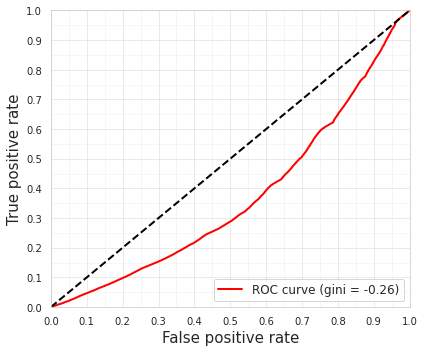

In [13]:
import matplotlib.pyplot as plt
plot_roc_curve(pddf_analisis.default60_12, pddf_analisis.MONTO, width=6, height=5)

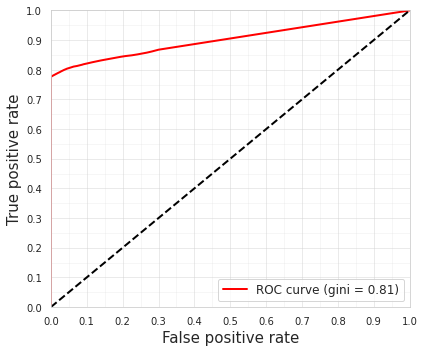

In [14]:
plot_roc_curve(pddf_analisis.default60_12, pddf_analisis.MAXATRASO_12, width=6, height=5)

In [ ]:

gini_res = pddf_analisis.groupby("MES_RCC").apply(lambda df: (roc_auc_score(df['default60_12'], 
                                                                            df['MONTO'])-0.5) * 200).reset_index(name='gini')

gini_res

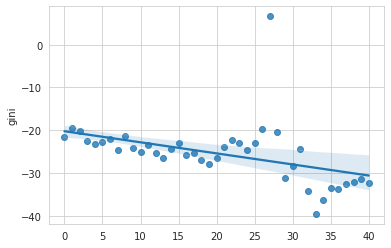

In [24]:

sns.regplot(x = gini_res.index, y = 'gini', data = gini_res)


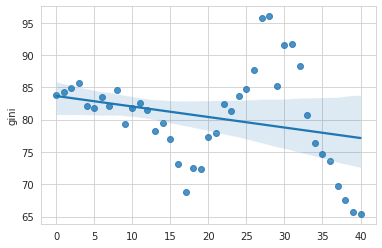

In [26]:
gini_res = pddf_analisis.groupby("MES_RCC").apply(lambda df: (roc_auc_score(df['default60_12'], 
                                                                            df['MAXATRASO_12'])-0.5) * 200).reset_index(name='gini')

sns.regplot(x = gini_res.index, y = 'gini', data = gini_res)


## Muestreo de data

In [ ]:
pddf_analisis

In [28]:
#Variables para el modelo

features = ['MES_RCC','ID', 'MONTO','MAXATRASO_12']

X = pddf_analisis[features]
y = pddf_analisis.default60_12

In [29]:
# Muestreo de data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    random_state = 123)

In [30]:
train = X_train
train['default60_12'] = y_train

test = X_test
test['default60_12'] = y_test

In [31]:

df_res = train.groupby('MES_RCC').aggregate({'ID': 'count',
                                            'MONTO': 'sum',
                                            'default60_12' : np.mean}).reset_index()
df_res.head()

,MES_RCC,ID,MONTO,default60_12
0,201801,11951,1.346567e+08,0.162832
1,201802,12096,1.444158e+08,0.160632
2,201803,13057,1.442577e+08,0.165735
3,201804,12738,1.454518e+08,0.166274
4,201805,12987,1.547521e+08,0.166936


In [32]:

df_res = test.groupby('MES_RCC').aggregate({'ID': 'count',
                                            'MONTO': 'sum',
                                            'default60_12' : np.mean}).reset_index()
df_res.head()

,MES_RCC,ID,MONTO,default60_12
0,201801,3033,36304809.26,0.159578
1,201802,2885,29468903.19,0.169151
2,201803,3189,33359388.92,0.178112
3,201804,3074,35143371.55,0.162004
4,201805,3245,38178917.84,0.180277


In [33]:
# Muestreo Estratificado de data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = pddf_analisis[['MES_RCC', 'default60_12']],
                                                    test_size = 0.3,
                                                    random_state = 123)

In [34]:
train = X_train
train['default60_12'] = y_train

test = X_test
test['default60_12'] = y_test

In [35]:
df_res = train.groupby('MES_RCC').aggregate({'ID': 'count',
                                            'MONTO': 'sum',
                                            'default60_12' : np.mean}).reset_index()
df_res.head()

,MES_RCC,ID,MONTO,default60_12
0,201801,10489,1.183426e+08,0.162170
1,201802,10487,1.188419e+08,0.162296
2,201803,11372,1.247500e+08,0.168132
3,201804,11068,1.258887e+08,0.165432
4,201805,11362,1.332298e+08,0.169600


In [36]:

df_res = test.groupby('MES_RCC').aggregate({'ID': 'count',
                                            'MONTO': 'sum',
                                            'default60_12' : np.mean}).reset_index()
df_res.head()

,MES_RCC,ID,MONTO,default60_12
0,201801,4495,52618897.25,0.162180
1,201802,4494,55042782.47,0.162216
2,201803,4874,52867118.80,0.168240
3,201804,4744,54706457.51,0.165472
4,201805,4870,59701159.31,0.169610


---

# Gracias por completar este laboratorio!

---
